In [78]:
import os
import IPython
import time
from keras.models import Sequential
from keras import layers, regularizers, optimizers
from keras.optimizers import RMSprop
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
import requests
import json
import numpy as np
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.externals import joblib 
import datetime

In [96]:
model = Sequential()
model.add(layers.CuDNNGRU(
    units=250, 
    input_shape=(None, 2),
    return_sequences=False,
    kernel_regularizer=None,
    recurrent_regularizer=None,
    bias_regularizer=None,
    activity_regularizer=None))
model.add(layers.Activation('tanh'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1))
model.add(layers.Activation('sigmoid'))
sgd = optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, amsgrad=True)
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
model.load_weights('best-weights.hdf5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnngru_4 (CuDNNGRU)       (None, 250)               190500    
_________________________________________________________________
activation_7 (Activation)    (None, 250)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 250)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 251       
_________________________________________________________________
activation_8 (Activation)    (None, 1)                 0         
Total params: 190,751
Trainable params: 190,751
Non-trainable params: 0
_________________________________________________________________


In [97]:
def getdata():
    auth_url = 'http://185.49.144.175/api/token/'
    bar_url = 'http://185.49.144.175/api/bars/?timeframe=1&for_predict=1'
    headers = {'Content-type': 'application/json', 'Content-Encoding': 'utf-8'}
    data = {"username": "lim","password": "Serialnomberr3"}
    answer = requests.post(auth_url, data=json.dumps(data), headers=headers)
    response = answer.json()
    token = response['access']
    headers = {'Authorization': 'Bearer ' + token}
    answer = requests.get(bar_url, headers=headers)
    response = answer.json()
    pred_data = np.zeros((30, 2))
    for i, bar in enumerate(response):
        pred_data[i][0] = response[29-i]['low'] - response[29-i]['high']
        pred_data[i][1] = response[29-i]['close']
    return pred_data

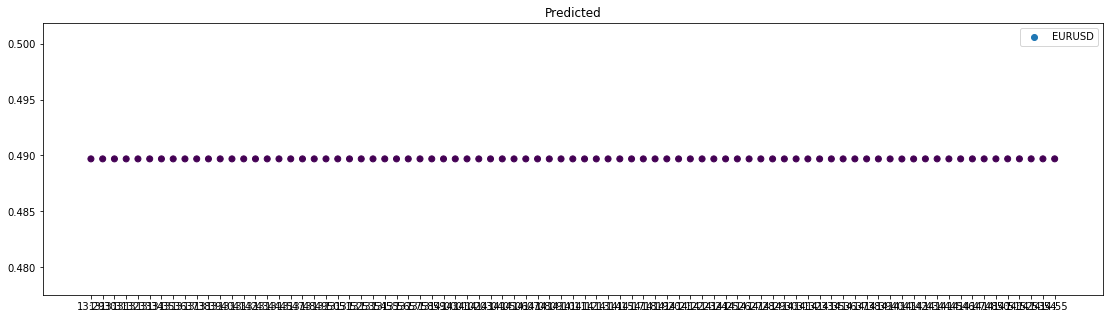

13:29 0.48969412
13:30 0.48969412
13:31 0.48969406
13:32 0.4896935
13:33 0.48969358
13:34 0.48969427
13:35 0.48969406
13:36 0.4896933
13:37 0.4896929
13:38 0.48969412
13:39 0.48969418
13:40 0.48969427
13:41 0.4896937
13:42 0.48969418
13:43 0.48969418
13:44 0.4896944
13:45 0.48969507
13:47 0.48969463
13:48 0.48969406
13:49 0.48969418
13:50 0.4896945
13:51 0.48969457
13:52 0.4896944
13:53 0.48969492
13:54 0.48969474
13:55 0.4896948
13:56 0.48969406
13:57 0.48969418
13:58 0.48969427
13:59 0.48969418
14:00 0.48969314
14:01 0.48969427
14:02 0.48969406
14:03 0.4896929
14:04 0.48969382
14:05 0.48969427
14:06 0.48969302
14:07 0.48969314
14:08 0.48969302
14:09 0.48969218
14:10 0.48969275
14:11 0.48969308
14:12 0.48969144
14:13 0.48969206
14:14 0.48969337
14:15 0.48969275
14:17 0.4896937
14:18 0.48969302
14:19 0.48969337
14:20 0.4896937
14:21 0.48969382
14:22 0.48969358
14:23 0.48969314
14:24 0.4896929
14:25 0.4896929
14:26 0.4896927
14:27 0.48969257
14:28 0.4896927
14:29 0.489692
14:30 0.489691

KeyboardInterrupt: 

In [100]:
import matplotlib.pyplot as plt
scores =[]#[1.1076618, 1.107682, 1.1077012, 1.107741, 1.107768, 1.107778, 1.1077605, 1.1077613, 1.10777, 1.107733, 1.1076846, 1.1076694, 1.1076717, 1.1077365, 1.1078457, 1.1079229, 1.107981, 1.1080071, 1.1080498, 1.1080985, 1.1081505, 1.108185, 1.1081992, 1.1081984, 1.1082242, 1.1082006, 1.1082023]
scores_bin =[]
times = []#list(range(len(scores)))
while 1:
    data = getdata()
    my_data_shaped = data.reshape(1,30,-1)
    score = model.predict(my_data_shaped)
    scores_bin.append(int(score[0][0]>0.5))
    scores.append(score[0][0])
    ti = datetime.datetime.now()+timedelta(minutes=10)
    times.append(ti.strftime("%H:%M"))
    plt.figure(figsize=(19,5))
    plt.scatter(times, scores, c=scores_bin, label='EURUSD')
    plt.title('Predicted')
    plt.legend()
    plt.show()
    for i, score1 in enumerate(scores):
        print(times[i], score1)
    time.sleep(60)
    IPython.display.clear_output()